In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout
from keras import backend as K

import math
from sklearn.metrics import mean_squared_error

np.set_printoptions(suppress=True)

Using TensorFlow backend.


### Understanding so far:
- Trying to find f such that f(c1, c2, time) = c3
- Because of time we need lstms.
- Final output is linear regression (continuous output)


### TODO:
- Understand how do I input time series data?? all data concatenated together and given together? what about 
  time then? 
- Combine all the data Nikki has shared.

## Reading all data

In [2]:
# Collecting all file names

c1_files = [file for file in glob.glob('../Nikki/Experimental Results' + '/**/C1.txt', recursive=True)]
c2_files = [file for file in glob.glob('../Nikki/Experimental Results' + '/**/C2.txt', recursive=True)]
c3_files = [file for file in glob.glob('../Nikki/Experimental Results' + '/**/C3.txt', recursive=True)]
print('Total c1, c2, c3 files:', len(c1_files), len(c2_files), len(c3_files))

Total c1, c2, c3 files: 44 44 44


In [3]:
# Reading data in all files
def read_files(files):
    x_all, y_all = [], []
    for file in files:
        x,y = [],[]
        for line in open(file, 'r'):
            words = [float(a) for a in line.strip().split(',')]
            x.append(words[0] * 1e09)
            y.append(words[1])
        x_all.append(x)
        y_all.append(y)
    return x_all, y_all

time_c1, c1 = read_files(c1_files)
time_c2, c2 = read_files(c2_files)
time_c3, c3 = read_files(c3_files)

## Check if all data is consistent

### Why are times different?

In [4]:
time_c1[0] == time_c2[0]

False

In [62]:
# The time gap seems fine to me.
np.set_printoptions(suppress=False)
for time_list1 in time_c3:
    time_lis1_diff = [y - x for x, y in zip(time_list1, time_list1[1:])]
    print(np.unique(np.round(time_lis1_diff, 3)))

[ 2.]
[ 2.     2.003]
[ 1.998  2.   ]
[ 2.]
[ 2.     2.003]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 1.998  2.   ]
[ 2.]
[ 2.]
[ 2.     2.003]
[ 2.]
[ 2.]
[ 2.     2.003]
[ 2.]
[ 2.]
[ 2.]
[ 2.]
[ 2.]


## So the problem is for most files c1, c2, c3 are not measured at the exact time Now if this difference is measurement was consistent across all files, then it is not a problem as we can later on offset the predicted values. But that is not the case. So we consider only that data where this measurement difference is 0 (9 files only!).

In [6]:
good_indices1 = []
for i, (time_list1, time_list2) in enumerate(zip(time_c1, time_c2)):
    time_lis1_diff = [y - x for x, y in zip(time_list1, time_list2)]
    print(np.unique(np.round(time_lis1_diff, 10)))
    if np.abs(np.unique(np.round(time_lis1_diff, 10))[0]) < 0.01:
        good_indices1.append(i)

good_indices2 = []
for i, (time_list1, time_list2) in enumerate(zip(time_c1, time_c3)):
    time_lis1_diff = [y - x for x, y in zip(time_list1, time_list2)]
    print(np.unique(np.round(time_lis1_diff, 10)))
    if np.abs(np.unique(np.round(time_lis1_diff, 10))[0]) < 0.01:
        good_indices2.append(i)
        
good_indices3 = []
for i, (time_list1, time_list2) in enumerate(zip(time_c2, time_c3)):
    time_lis1_diff = [y - x for x, y in zip(time_list1, time_list2)]
    print(np.unique(np.round(time_lis1_diff, 10)))
    if np.abs(np.unique(np.round(time_lis1_diff, 10))[0]) < 0.01:
        good_indices3.append(i)        

[-0.86]
[ 0.12]
[-1.26     -1.255004 -1.255    -1.254996]
[ 0.]
[ 0.63]
[ 0.84       0.8400001]
[-0.7050001 -0.705    ]
[ 1.03       1.0300001]
[-0.13]
[-1.4050001 -1.405    ]
[-1.11500006 -1.115     ]
[ 0.11]
[ 1.7]
[-0.4]
[ 0.07]
[-0.45]
[-0.92]
[-1.885]
[ 21.635]
[ 0.54]
[-0.51]
[-0.105]
[ 1.13       1.1300001]
[-0.12]
[-0.79]
[-0.86]
[-0.29]
[-0.925      -0.92499996]
[ 0.5        0.5000001]
[ 0.215]
[ 0.]
[-0.44]
[ 0.825]
[-5.228]
[-1.57001 -1.57    -1.56999]
[ 0.]
[ 0.]
[ 0.]
[ 1.099997  1.1       1.100003]
[ 0.]
[ 0.]
[ 0.]
[-0.16]
[ 0.]
[-0.285]
[-0.920004 -0.92     -0.919996]
[-0.62  -0.615]
[ 0.]
[ 1.294996  1.295     1.295004  1.3     ]
[ 0.13       0.1300001]
[-0.58]
[ 0.17]
[ 0.6        0.6000001]
[-1.3450001 -1.345    ]
[-1.0100001 -1.01     ]
[-0.67]
[ 1.14]
[ 0.58]
[-1.25]
[-0.13]
[-0.25]
[-1.89]
[ 21.13]
[-1.2900001 -1.29     ]
[-1.035]
[ 1.465]
[ 1.71       1.7100001]
[ 0.2]
[ 0.77]
[-0.285]
[ 1.38]
[ 0.66       0.6600001]
[ 0.56       0.5600001]
[ 0.255]
[ 0.]
[-0.215

In [7]:
print(good_indices1)
print(good_indices2)
print(good_indices3)

[3, 30, 35, 36, 37, 39, 40, 41, 43]
[3, 30, 35, 36, 37, 39, 40, 41, 43]
[3, 17, 30, 35, 36, 37, 39, 40, 41, 43]


In [8]:
best_indices = sorted(list(set(good_indices3).intersection(set(good_indices1).intersection(set(good_indices2)))))
best_indices

[3, 30, 35, 36, 37, 39, 40, 41, 43]

In [9]:
final_c1 = [t for i, t in enumerate(c1) if i in best_indices]
final_c2 = [t for i, t in enumerate(c2) if i in best_indices]
final_c3 = [t for i, t in enumerate(c3) if i in best_indices]

final_time_c1 = [t for i, t in enumerate(time_c1) if i in best_indices]
final_time_c2 = [t for i, t in enumerate(time_c2) if i in best_indices]
final_time_c3 = [t for i, t in enumerate(time_c3) if i in best_indices]

len(best_indices), len(final_c1), len(final_c2), len(final_c3)

(9, 9, 9, 9)

In [10]:
# final_c1, final_c2, final_c3 = c1, c2, c3
# final_time_c1, final_time_c2, final_time_c3 = time_c1, time_c2, time_c3

### Some files of different lengths

In [11]:
len_c1 = np.array([len(a) for a in final_c1])
len_c2 = np.array([len(a) for a in final_c2])
len_c3 = np.array([len(a) for a in final_c3])

def check_inconsistent_data(data1, data2):
    print('File index where data is of different lengths:', np.where(data1 != data2)[0])
    print('Different lengths are:', data1[data1 != data2], data2[data1 != data2])

check_inconsistent_data(len_c1, len_c2)
check_inconsistent_data(len_c1, len_c3)
check_inconsistent_data(len_c2, len_c3)

File index where data is of different lengths: []
Different lengths are: [] []
File index where data is of different lengths: []
Different lengths are: [] []
File index where data is of different lengths: []
Different lengths are: [] []


## Lets plot a few files to understand them!

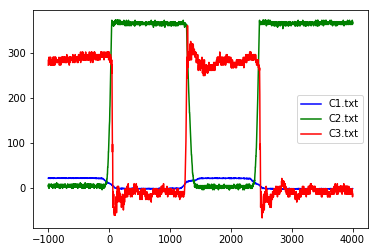

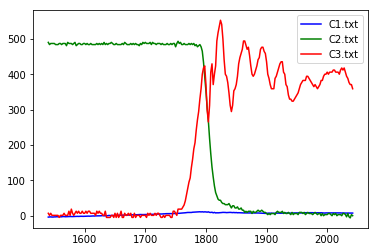

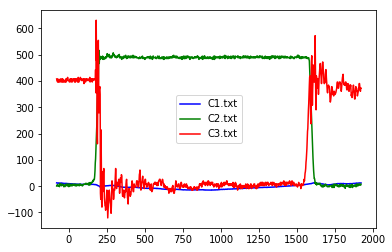

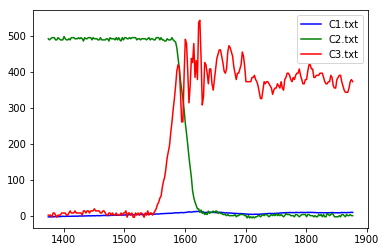

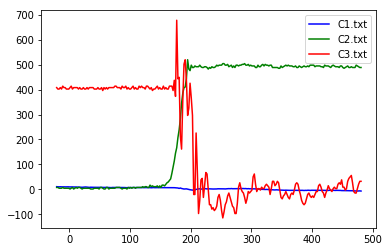

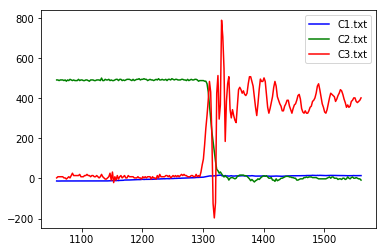

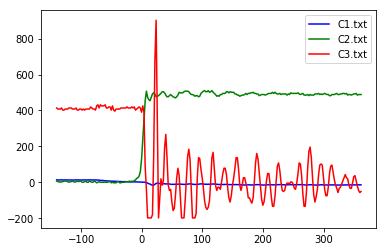

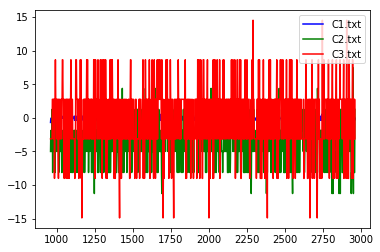

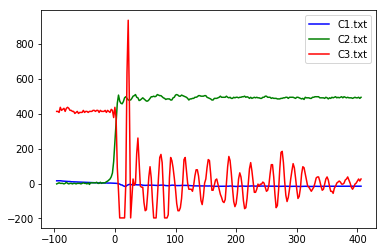

In [12]:
# Change file_indices to see different plots
file_indices = range(9)

for file_index in file_indices:
    plt.figure()
    plt.plot(final_time_c1[file_index], final_c1[file_index], c = 'b', label='C1.txt')
    plt.plot(final_time_c2[file_index], final_c2[file_index], c = 'g', label='C2.txt')
    plt.plot(final_time_c3[file_index], final_c3[file_index], c = 'r', label='C3.txt')
    plt.legend()

### Remove inconsistent data - file indices 32 and 33 - to be done only when using all the 44 files
- Note that index 33 becomes 32 once index 32 is removed!

In [71]:
# del c1[32]
# del c1[32]
# del c2[32]
# del c2[32]
# del c3[32]
# del c3[32]

In [13]:
# Confirm again if inconsistent data has been removed
len_c1 = np.array([len(a) for a in final_c1])
len_c2 = np.array([len(a) for a in final_c2])
len_c3 = np.array([len(a) for a in final_c3])

print('lengths: ', len_c1)
print('lengths: ', len_c2)
print('lengths: ', len_c3)
check_inconsistent_data(len_c1, len_c2)
check_inconsistent_data(len_c1, len_c3)
check_inconsistent_data(len_c2, len_c3)

lengths:  [2502  252 1002  252  252  252  252 1002  252]
lengths:  [2502  252 1002  252  252  252  252 1002  252]
lengths:  [2502  252 1002  252  252  252  252 1002  252]
File index where data is of different lengths: []
Different lengths are: [] []
File index where data is of different lengths: []
Different lengths are: [] []
File index where data is of different lengths: []
Different lengths are: [] []


## Split into training and testing data - not using validation data as of now!
#### Using approx 80% of files of training and remaining for testing

In [14]:
SPLIT = 0.9
total_files = len(final_c1)
print('Total files: ', total_files)

c1_train = final_c1[0:int(SPLIT * total_files)]
c2_train = final_c2[0:int(SPLIT * total_files)]
c3_train = final_c3[0:int(SPLIT * total_files)]
c1_test = final_c1[int(SPLIT * total_files):]
c2_test = final_c2[int(SPLIT * total_files):]
c3_test = final_c3[int(SPLIT * total_files):]

print('Train files: ', len(c1_train))
print('Test files: ', len(c1_test))

Total files:  9
Train files:  8
Test files:  1


## Generate input and output time series data for the NN model

In [15]:
# Create a time unrolled dataset for each set of c1, c2, c3 files
def create_data_per_file(c1_file, c2_file, c3_file, look_back=10):
    x_all, y_all = [], []
    for i in range(len(c1_file) - look_back + 1):
        a = np.concatenate((np.array(c1_file[i:(i + look_back)]).reshape(-1, 1), 
                            np.array(c2_file[i:(i + look_back)]).reshape(-1, 1)), axis = 1)
        x_all.append(a)
        y_all.append(c3_file[i + look_back - 1])
    return np.array(x_all), np.array(y_all)


def create_data_for_all_files(c1_allfiles, c2_allfiles, c3_allfiles, 
                              batch_size=243, batch_overlap=10, look_back=10):
    x_all, y_all = [], []

    for c1_file, c2_file, c3_file in zip(c1_allfiles, c2_allfiles, c3_allfiles):
        x, y = create_data_per_file(c1_file, c2_file, c3_file, look_back)

        # Don't consider such data
        if x.shape[0] < batch_size:
            continue

        # Need to split the data further into arrays of size batch_size
        elif x.shape[0] > batch_size:
            x_list, y_list = [], []
            for i in range(int((x.shape[0] - batch_size) / batch_overlap) + 1):
                x_list.append(x[i * batch_overlap:(i * batch_overlap + batch_size)])
                y_list.append(y[i * batch_overlap:(i * batch_overlap + batch_size)])
            x_all.extend(x_list)
            y_all.extend(y_list)

        else:
            x_all.append(x)
            y_all.append(y)
    return np.array(x_all).reshape(-1, batch_size, look_back, 2), np.array(y_all).reshape(-1, batch_size, 1)

In [100]:
# loop_back is the time series information. If loop_back is 10, it means we are considering the past 10 
# data points (c1, c2) to predict the current c3.
# Batch_size was decided because the minimum length of most graphs were 252. 
# So batch_size becomes 252 - loop_back + 1
# We need batch_overlap because some graphs are of size > 252. Then we need to split them further. So to split
# and to maintain some time series information, we move ahead by only batch_overlap to choose the next batch_size 
# points.
look_back = 10
batch_size = 252 - look_back + 1
batch_overlap = 1

X_train, y_train = create_data_for_all_files(c1_train, c2_train, c3_train, 
                                             batch_size=batch_size, 
                                             batch_overlap=batch_overlap, 
                                             look_back=look_back)
X_test, y_test = create_data_for_all_files(c1_test, c2_test, c3_test, 
                                           batch_size=batch_size, 
                                           batch_overlap=batch_overlap, 
                                           look_back=look_back)

# The shape should be num_batches x batch_size x loop_back x num_features
# num_features for X is 2 and for y is 1
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3758, 243, 10, 2) (3758, 243, 1)
(1, 243, 10, 2) (1, 243, 1)


In [101]:
# We need to concatenate all of the data points
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(913194, 10, 2) (913194, 1)
(243, 10, 2) (243, 1)


## z-score data for the NN model

In [102]:
x_mean = np.mean(np.concatenate(X_train, axis=0), axis=0)
x_std = np.std(np.concatenate(X_train, axis=0), axis=0)
print(x_mean, x_std)

y_mean = np.mean(y_train, axis=0)
y_std = np.std(y_train, axis=0)
print(y_mean, y_std)

[   3.32050921  215.25117848] [  10.25115267  205.61143646]
[ 83.27035168] [ 138.67912064]


In [103]:
X_train = (X_train - x_mean) / x_std
X_test = (X_test - x_mean) / x_std

y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

## Stateful Model

In [108]:
# batch_size = defined above for data generation
# look_back = defined above for data generation
K.set_floatx('float64')
features = 2  # c1, c2
l2_decay = 1e-6

model = Sequential()
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, features), stateful=True, return_sequences=True, 
               kernel_regularizer=l2(l2_decay)))
model.add(Dropout(0.5))
model.add(LSTM(32, stateful=True, return_sequences=True, kernel_regularizer=l2(l2_decay)))
model.add(Dropout(0.5))
model.add(LSTM(32, stateful=True, kernel_regularizer=l2(l2_decay)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=200, verbose=1, shuffle=False)

Epoch 1/200
913194/913194 [==============================] - 119s - loss: 0.0560   
Epoch 2/200
913194/913194 [==============================] - 111s - loss: 0.0719   
Epoch 3/200
913194/913194 [==============================] - 112s - loss: 0.0545   
Epoch 4/200
913194/913194 [==============================] - 112s - loss: 0.0631   
Epoch 5/200
913194/913194 [==============================] - 112s - loss: 0.0544   
Epoch 6/200
913194/913194 [==============================] - 111s - loss: 0.0473   
Epoch 7/200
913194/913194 [==============================] - 113s - loss: 0.0442   
Epoch 8/200
913194/913194 [==============================] - 112s - loss: 0.0473   
Epoch 9/200
913194/913194 [==============================] - 120s - loss: 0.0438   
Epoch 10/200
913194/913194 [==============================] - 114s - loss: 0.0466   
Epoch 11/200
913194/913194 [==============================] - 112s - loss: 0.0442   
Epoch 12/200
913194/913194 [==============================] - 111s - loss:

913194/913194 [==============================] - 111s - loss: 0.0396   
Epoch 98/200
913194/913194 [==============================] - 112s - loss: 0.0394   
Epoch 99/200
913194/913194 [==============================] - 113s - loss: 0.0393   
Epoch 100/200
913194/913194 [==============================] - 111s - loss: 0.0406   
Epoch 101/200
913194/913194 [==============================] - 112s - loss: 0.0402   
Epoch 102/200
913194/913194 [==============================] - 113s - loss: 0.0392   
Epoch 103/200
913194/913194 [==============================] - 111s - loss: 0.0393   
Epoch 104/200
913194/913194 [==============================] - 112s - loss: 0.0409   
Epoch 105/200
913194/913194 [==============================] - 111s - loss: 0.0393   
Epoch 106/200
913194/913194 [==============================] - 114s - loss: 0.0397   
Epoch 107/200
913194/913194 [==============================] - 112s - loss: 0.0393   
Epoch 108/200
913194/913194 [==============================] - 112s - 

913194/913194 [==============================] - 104s - loss: 0.0356   
Epoch 193/200
913194/913194 [==============================] - 104s - loss: 0.0361   
Epoch 194/200
913194/913194 [==============================] - 104s - loss: 0.0358   
Epoch 195/200
913194/913194 [==============================] - 104s - loss: 0.0379   
Epoch 196/200
913194/913194 [==============================] - 104s - loss: 0.0365   
Epoch 197/200
913194/913194 [==============================] - 104s - loss: 0.0373   
Epoch 198/200
913194/913194 [==============================] - 104s - loss: 0.0366   
Epoch 199/200
913194/913194 [==============================] - 104s - loss: 0.0358   
Epoch 200/200
913194/913194 [==============================] - 104s - loss: 0.0363   


In [115]:
model.save('models/gan_10_10_epoch_200_v2.h5')

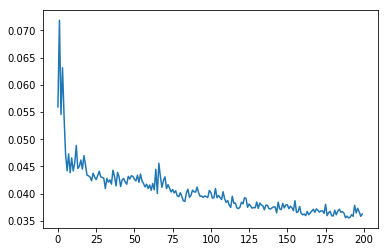

In [109]:
plt.plot(history.epoch, history.history['loss'])

## Plotting for one test file

In [112]:
y_pred = model.predict(X_test, batch_size=batch_size)
print(X_test.shape, y_test.shape, y_pred.shape)

(243, 10, 2) (243, 1) (243, 1)


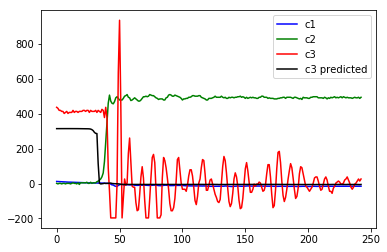

In [114]:
plot_length = batch_size
plt.plot(range(plot_length), (X_test[:, -1, 0] * x_std[0]) + x_mean[0], c='b', label='c1')
plt.plot(range(plot_length), (X_test[:, -1, 1] * x_std[1]) + x_mean[1], c='g', label='c2')
plt.plot(range(plot_length), (y_test * y_std) + y_mean, c='r', label='c3')
plt.plot(range(plot_length), (y_pred * y_std) + y_mean, c='k', label='c3 predicted')
plt.legend()

## Plotting for train

In [99]:
len(c1_train[1])
batch_overlap

1

In [98]:
file_id = 2
X_t, y_t = create_data_for_all_files([c1_train[file_id]], [c2_train[file_id]], [c3_train[file_id]], 
                                     batch_size=batch_size, 
                                     batch_overlap=batch_overlap, 
                                     look_back=look_back)
print(X_t.shape, y_t.shape)

(751, 233, 20, 2) (751, 233, 1)


In [96]:
y_p = model.predict((X_t[1] - x_mean)/x_std, batch_size=batch_size)

233


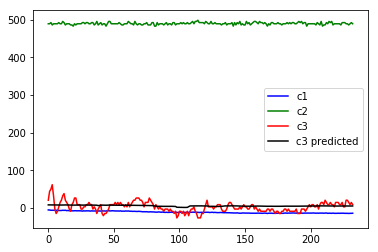

In [97]:
id = 1
plot_length = batch_size
print(plot_length)
plt.plot(range(plot_length), X_t[id, :, -1, 0], c='b', label='c1')
plt.plot(range(plot_length), X_t[id, :, -1, 1], c='g', label='c2')
plt.plot(range(plot_length), y_t[id], c='r', label='c3')
plt.plot(range(plot_length), (y_p * y_std) + y_mean, c='k', label='c3 predicted')
plt.legend()

983


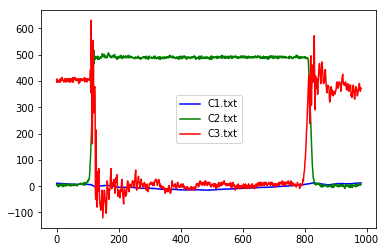

In [89]:
_l = len(c1_train[file_id][19:])
print(_l)
plt.plot(range(_l), c1_train[file_id][19:], c = 'b', label='C1.txt')
plt.plot(range(_l), c2_train[file_id][19:], c = 'g', label='C2.txt')
plt.plot(range(_l), c3_train[file_id][19:], c = 'r', label='C3.txt')
plt.legend()

In [105]:
model.save('models/gan_10_10_epoch_40_v1.h5')